In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
sys.path.append(p)

# from scripts.utils import *
# from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
meta_file = '/Users/fairliereese/Documents/programming/mele_lab/projects/240706_pantranscriptome_cerberus_gtf_merge/ref/pantranscriptome_samples_metadata.tsv'

## Fix gene annots

In [13]:
df = pd.read_csv('agg_ics.tsv', sep='\t')
df['gid'] = df['Name'].str.rsplit('_', expand=True)[0]
df.loc[df.gid=='NA']

,Chromosome,Strand,Coordinates,Name,source,novelty,gid
385140,GL000219.1,+,98742-99125,NA_1,"GM19117_1,GM19129_1,GM19240_1,GM18561_1,GM1863...",NNC,NA
385141,chr1,-,101410091-101396768,NA_2,"GM19117_1,GM19129_1,GM18561_1,GM18774_1,GM1930...",NNC,NA
385143,chr1,-,101410091-101406651-101406493-101396768,NA_3,"GM19117_1,GM19129_1,GM18561_1,GM10492_1,GM1930...",NNC,NA
385145,chr1,-,101410311-101410211-101410091-101396768,NA_4,"GM19117_1,GM19129_1,GM19352_1,GM19390_1,GM2229...",NNC,NA
385148,chr1,-,101448575-101396768,NA_5,"GM19117_1,GM19240_1,GM18561_1,GM10492_1,GM1939...",NNC,NA
...,...,...,...,...,...,...,...
404589,chrX,-,126994097-126993619,NA_10496,GM19093_1,NNC,NA
404590,chrX,-,136935901-136932529,NA_10497,GM19093_1,NNC,NA
404591,chrX,-,15158710-15157670,NA_10498,GM19093_1,NNC,NA
404592,chrX,-,48071064-48069072,NA_10499,GM19093_1,NNC,NA


In [22]:
df = pd.read_csv('agg_ics.tsv', sep='\t')
df.source = df.source.astype('str')
df['gene_id'] = df.Name.str.rsplit('_', n=1, expand=True)[0]

# reannotate novel genes novelty
# df.loc[df.Name.str.contains('novel'), 'novelty'] = 'Intergenic' # this is the isoquant way of telling
df.loc[df.gene_id=='NA', 'novelty'] = 'Intergenic'

# df.loc[~df.source.str.contains('47')].novelty.unique()

# # get only the novel transcripts
# df = df.loc[~df.source.str.contains('47')]

# get the transcripts that are expressed 
# df = df.loc[df.source.str.contains(',')]

# get ic : sample info
df['source'] == df['source'].astype('str')
df['source'] = df.source.str.split(',')
df = df[['Name', 'source', 'novelty', 'Chromosome', 'Coordinates', 'gene_id']].explode('source')

df['sample'] = df.source.str.split('_', expand=True)[0]

# get population info
meta = pd.read_csv(meta_file, sep='\t')
df = df.merge(meta[['sample', 'population']], how='left', on='sample')

In [23]:
df.novelty.unique()

array(['Known', 'NNC', 'Intergenic', 'NIC', 'ISM'], dtype=object)

In [24]:
df.loc[df.gene_id.isnull()].head()
df.loc[df.gene_id == ''].head()

,Name,source,novelty,Chromosome,Coordinates,gene_id,sample,population


In [25]:
# count the number of known and novel genes that match with each novel IC (no unspliced)
temp = df.loc[df.Coordinates != '-']
temp[['novelty', 'Chromosome', 'Coordinates', 'gene_id']].head()

,novelty,Chromosome,Coordinates,gene_id
0,Known,GL000008.2,170271-157581-157527-154715-154562-153412,ENSG00000296775
1,Known,GL000008.2,170271-163998-163784-162439,ENSG00000296775
2,Known,GL000008.2,170271-163998-163784-162439,ENSG00000296775
3,Known,GL000008.2,170271-163998-163784-162439,ENSG00000296775
4,Known,GL000008.2,170271-163998-163784-162439,ENSG00000296775


In [26]:
temp= df[['Chromosome', 'Coordinates', 'gene_id', 'novelty']]
temp = temp.loc[temp.Coordinates!='-']
temp = temp.loc[temp.novelty=='Known']
temp.drop('novelty', axis=1, inplace=True)
temp = temp.groupby(['Chromosome', 'Coordinates']).nunique().reset_index().rename({'gene_id':'n_genes'}, axis=1)
temp.head()

,Chromosome,Coordinates,n_genes
0,GL000008.2,170271-157581-157527-154715-154562-153412,1
1,GL000008.2,170271-163998-163784-162439,1
2,GL000008.2,170271-164884-164584-163998-163784-162439,1
3,GL000008.2,170271-164884-164602-157581,1
4,GL000008.2,170271-164884-164602-163998-163784-157581,1


In [27]:
temp = temp.loc[temp.n_genes>1]
temp2 = df.loc[df.novelty!='Known']
temp2 = temp2[['Chromosome', 'Coordinates', 'novelty']]
temp2 = temp2.merge(temp, how='inner', on=['Chromosome', 'Coordinates'])

In [28]:
len(temp2[['Chromosome', 'Coordinates']].drop_duplicates())

0

In [29]:
22

22

## How many NNCs have no known gene in annot?

In [30]:
df = pd.read_csv('agg_ics.tsv', sep='\t')
# convert source dtype to str
df['source'] = df['source'].astype(str)
df['gene_id'] = df.Name.str.split('_', n=1, expand=True)[0]
# reannotate novel genes novelty
# df.loc[df.Name.str.contains('novel'), 'novelty'] = 'Intergenic'
df.loc[df.gene_id=='NA', 'novelty'] = 'Intergenic'
known_gids = df.loc[df.source.str.contains('47'), 'gene_id'].unique().tolist()
df['gene_novelty'] = 'Novel'
df.loc[df.gene_id.isin(known_gids), 'gene_novelty'] = 'Known'
df[['Name', 'gene_novelty', 'novelty']].groupby(['gene_novelty', 'novelty']).nunique().rename({'Name':'n_ic'}, axis=1).reset_index()

,gene_novelty,novelty,n_ic
0,Known,ISM,4079
1,Known,Known,385139
2,Known,NIC,1470
3,Known,NNC,3408
4,Novel,Intergenic,10500


## how many known genes does each IC overlap with ?

In [31]:
# temp = temp.loc[temp.Coordinates!='-']
# temp = temp[['Coordinates'

In [32]:
# # ensure no overlap b/w "novel" ICs
# # assert len(temp.loc[temp.source.str.contains(',')]) == 0
# temp.loc[temp.source.str.contains(',')]

In [33]:
df.loc[df.Coordinates=='99969304-99968477']

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,gene_novelty
19782,chr1,-,99969304-99968477,ENSG00000228084_2,"47,GM19117_1,GM19129_1,GM19240_1,GM18561_1,GM1...",Known,ENSG00000228084,Known


In [ ]:
len(df.index)

In [4]:
temp = df[['Name', 'novelty']].groupby('novelty').nunique()
temp

,Name
novelty,
ISM,889
NIC,426
NNC,57696


In [5]:
# d = meta[['population', 'color']].drop_duplicates().set_index('population').to_dict(orient='index')
# d = dict([(k, i['color']) for k,i in d.items()])

In [88]:
c_dict, order = get_pop_colors()

In [89]:
df = pd.read_csv('agg_ics.tsv', sep='\t')
df.head()

,Chromosome,Strand,Coordinates,Name,source,novelty
0,GL000008.2,-,170271-157581-157527-154715-154562-153412,ENSG00000296775_5,47,Known
1,GL000008.2,-,170271-163998-163784-162439,ENSG00000296775_6,"47,GM22234_1,GM19093_1,GM10493_1,GM10496_1",Known
2,GL000008.2,-,170271-164884-164584-163998-163784-162439,ENSG00000296775_7,47,Known
3,GL000008.2,-,170271-164884-164602-157581,ENSG00000296775_8,47,Known
4,GL000008.2,-,170271-164884-164602-163998-163784-157581,ENSG00000296775_9,"47,GM22234_1",Known


In [40]:

df = pd.read_csv('agg_ics.tsv', sep='\t')

# reannotate novel genes novelty
df['gene_id'] = df.Name.str.split('_', n=1, expand=True)[0]
# reannotate novel genes novelty
# df.loc[df.Name.str.contains('novel'), 'novelty'] = 'Intergenic' # isoquant
df.loc[df.gene_id=='NA', 'novelty'] = 'Intergenic' # espresso

# get ic : sample info
df['source'] = df.source.str.split(',')
df = df[['Name', 'source', 'novelty']].explode('source')
df['sample'] = df.source.str.split('_', expand=True)[0]

# remove things from gencode
print(len(df.index))
df = df.loc[df.source!='47']
print(len(df.index))

# get population info
meta = pd.read_csv(meta_file, sep='\t')
df = df.merge(meta[['sample', 'population']], how='left', on='sample')
df.drop('source', axis=1, inplace=True)

# remove duplicates that were detected in the tech reps of the same sample
print(len(df.index))
df.drop_duplicates(inplace=True)
print(len(df.index))



1866310
1481171
1481171
1481171


In [ ]:
df.loc[df.novelty=='Intergenic']

In [ ]:
# temp = df[['Name', 'source']].groupby('Name').nunique().reset_index().rename({'source':'n_tech_reps'}, axis=1)
# temp.sort_values(by='n_tech_reps', ascending=False).head()

In [41]:
# count of # samples in a population that have each IC
temp = df.groupby(['Name', 'novelty', 'population']).nunique().reset_index().rename({'sample':'n_samples'}, axis=1)
temp.loc[temp.n_samples>1]

,Name,novelty,population,n_samples
2,ENSG00000000003_1,Known,HAC,4
4,ENSG00000000003_1,Known,LWK,2
5,ENSG00000000003_1,Known,MPC,4
6,ENSG00000000003_1,Known,PEL,4
7,ENSG00000000003_1,Known,YRI,4
...,...,...,...,...
478269,NA_998,Intergenic,HAC,3
478270,NA_998,Intergenic,ITU,2
478272,NA_998,Intergenic,MPC,2
478273,NA_998,Intergenic,PEL,3


In [42]:
# count of # of ICs that have n number of samples
temp2 = temp.groupby(['n_samples', 'novelty', 'population']).nunique().reset_index().rename({'Name':'n_ics'}, axis=1)

In [43]:
# make these plots, then adjust max values
init_plot_settings(subplot_r=len(temp.population.unique()),
                   subplot_c=len(temp.novelty.unique()))
# temp2 = temp.loc[(temp.novelty=='ISM')&(temp.population=='AJI')]
# g = sns.FacetGrid(temp, col='population', row='novelty')
# g.map(sns.barplot, temp,
#             'n_samples',
#             'n_ics')
#             # saturation=1,
#             # col='population',
#             # row='novelty',
#             # hue='population',
#             # palette=c_dict)
# sns.catplot(temp2,
#             kind='bar',
#             x='n_samples',
#             y='n_ics',
#             saturation=1,
#             col='population',
#             row='novelty',
#             sharey='row')

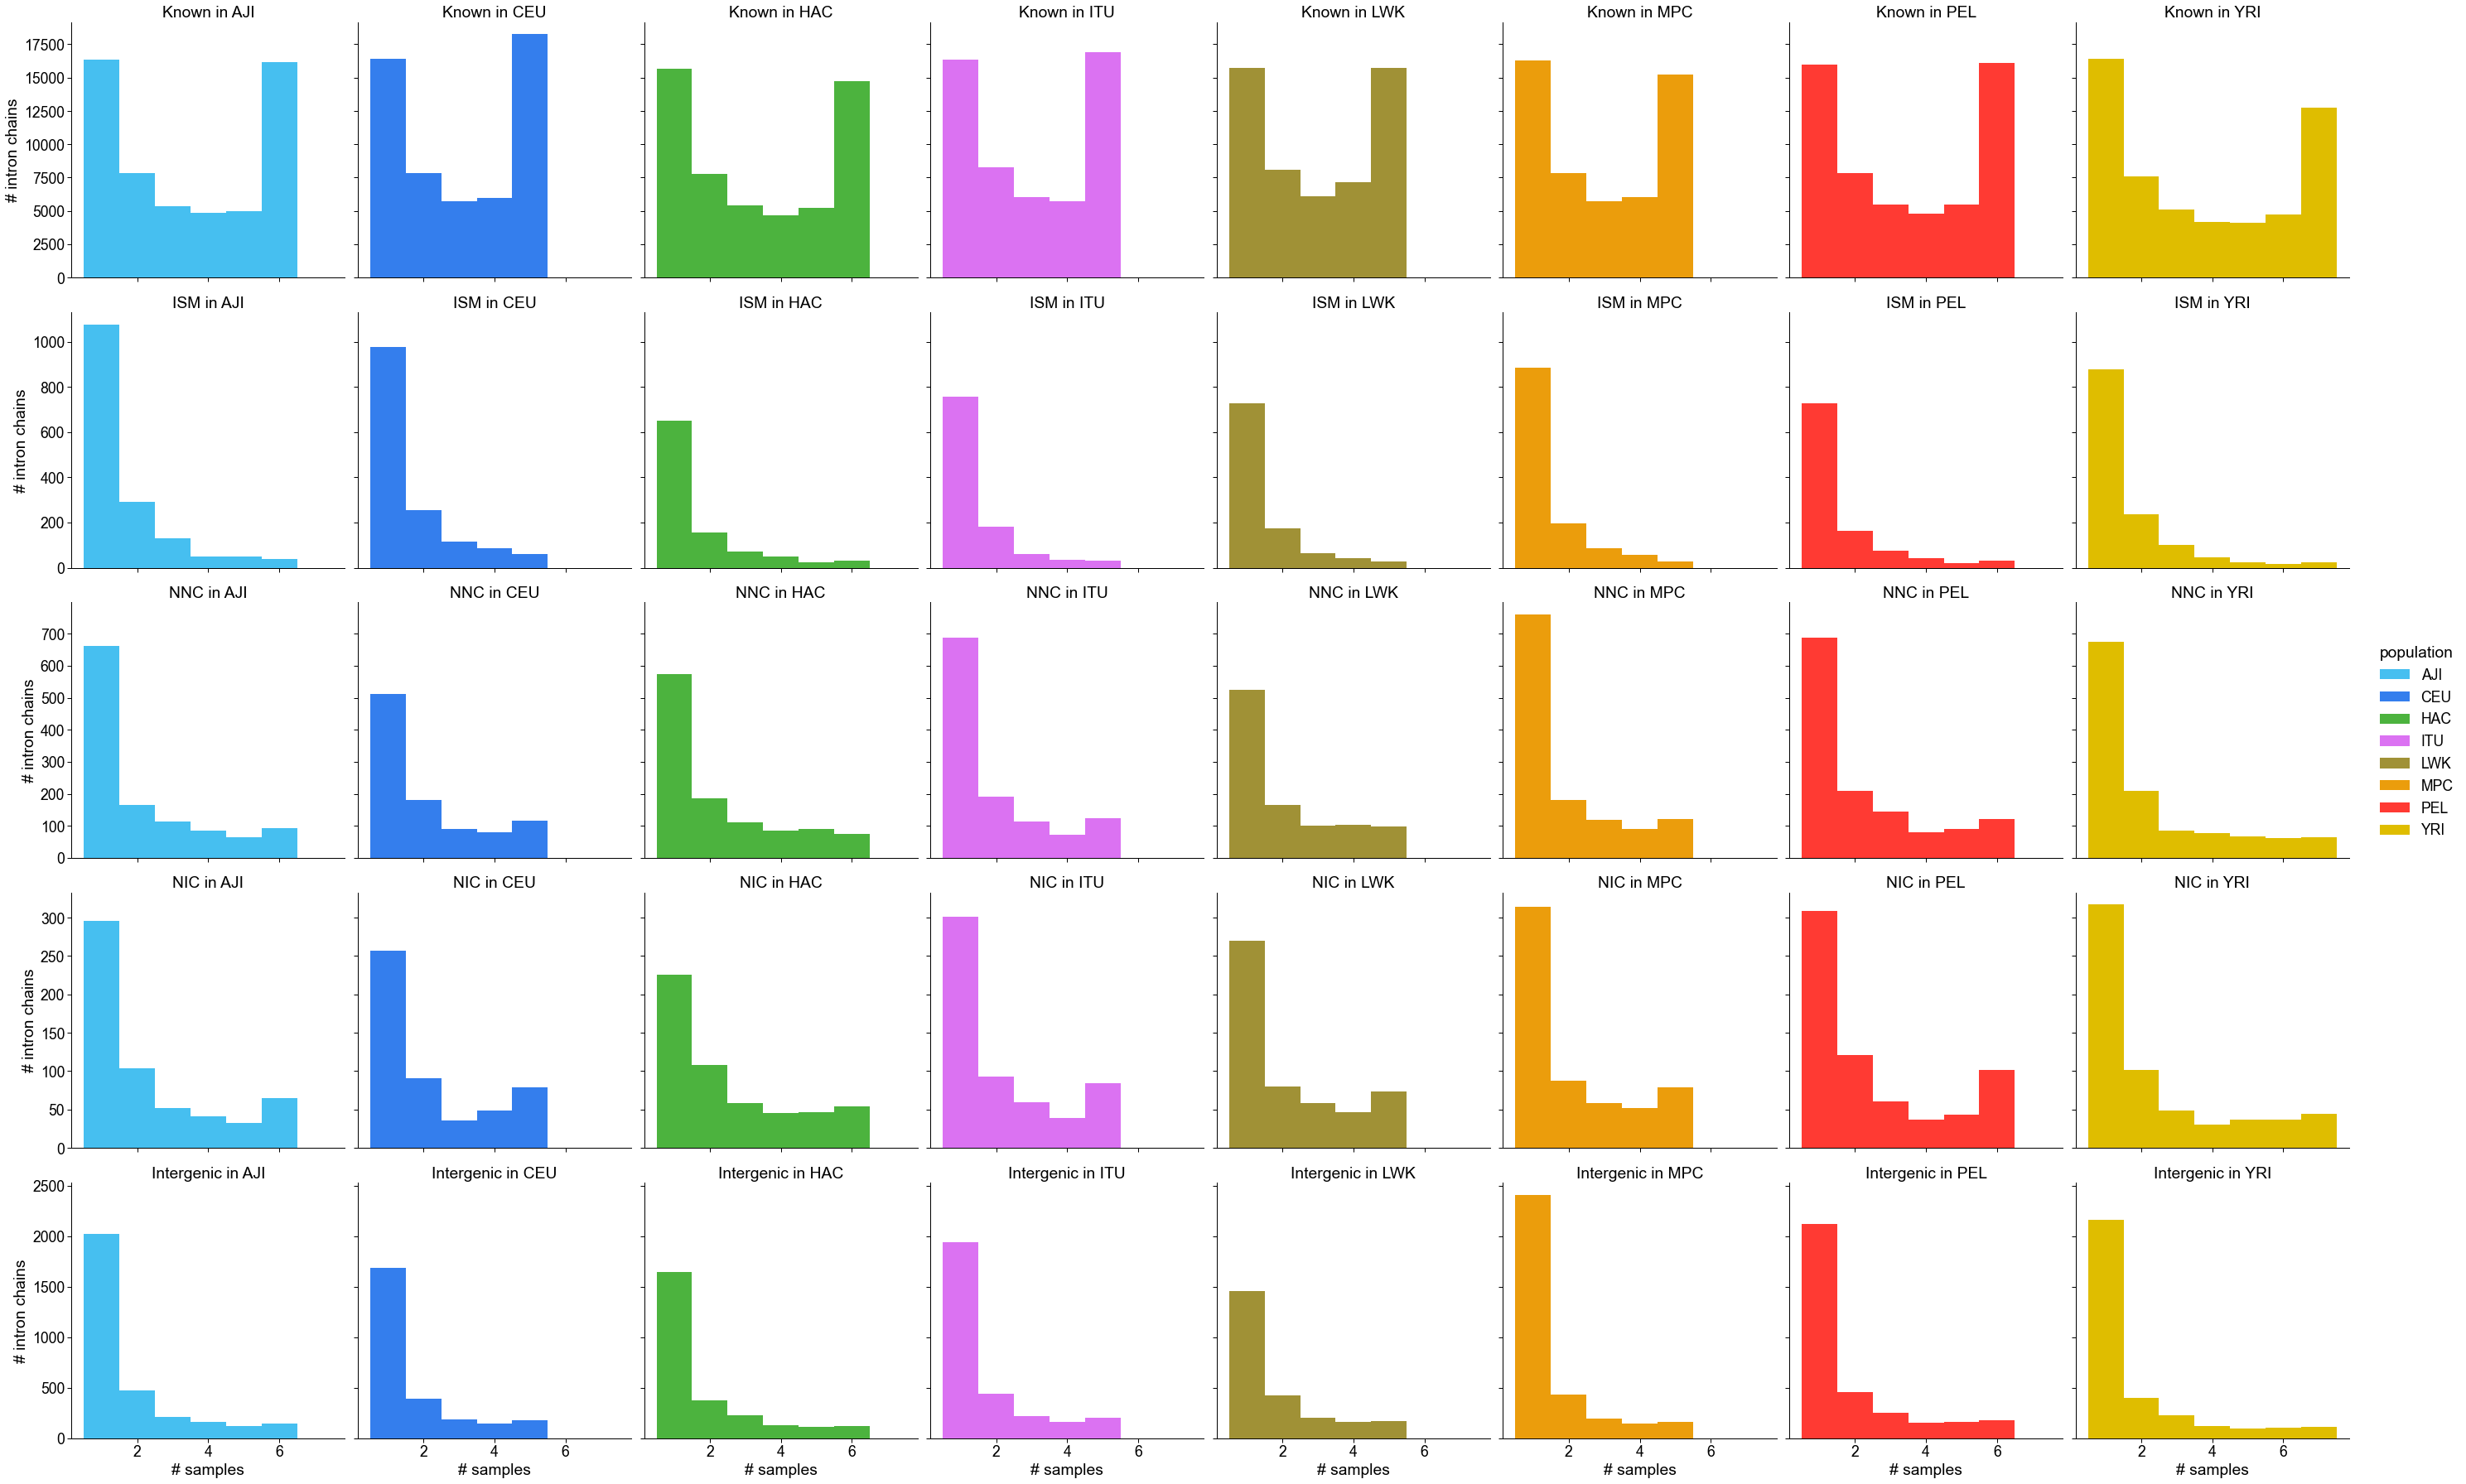

In [44]:

c_dict, order = get_pop_colors()
init_plot_settings(font_scale=3)
g = sns.displot(temp,
            kind='hist',
            x='n_samples',
            alpha=1,
            discrete=True,
            col='population',
            row='novelty',
            edgecolor=None,
            hue='population',
            palette=c_dict,
            facet_kws=dict(sharey='row'))
g.set_axis_labels('# samples', '# intron chains')
g.set_titles('{row_name} in {col_name}')

## Global summary statistics of IC reproducibility per novelty cat

In [45]:
c_dict, order = get_talon_nov_colors(cats=df.novelty.unique().tolist())

In [46]:
df = pd.read_csv('agg_ics.tsv', sep='\t')

# reannotate novel genes novelty
df['gene_id'] = df.Name.str.split('_', n=1, expand=True)[0]
# reannotate novel genes novelty
# df.loc[df.Name.str.contains('novel'), 'novelty'] = 'Intergenic' # isoquant
df.loc[df.gene_id=='NA', 'novelty'] = 'Intergenic' # espresso

# df.loc[~df.source.str.contains('47')].novelty.unique()

# # get only the novel transcripts
# df = df.loc[~df.source.str.contains('47')]

# get the transcripts that are expressed 
# df = df.loc[df.source.str.contains(',')]

# get ic : sample info
df['source'] = df.source.str.split(',')
df = df[['Name', 'source', 'novelty']].explode('source')
df['sample'] = df.source.str.split('_', expand=True)[0]

# remove things from gencode
print(len(df.index))
df = df.loc[df.source!='47']
print(len(df.index))

# get population info
meta = pd.read_csv(meta_file, sep='\t')
df = df.merge(meta[['sample', 'population']], how='left', on='sample')
df.drop('source', axis=1, inplace=True)

# remove duplicates that were detected in the tech reps of the same sample
print(len(df.index))
df.drop_duplicates(inplace=True)
print(len(df.index))

1866310
1481171
1481171
1481171


In [47]:
# get the number of samples each ic is in
df = df[['Name', 'novelty', 'sample']].groupby(['Name', 'novelty']).nunique().rename({'sample':'n_samples'}, axis=1).reset_index()
# df = df.groupby(['novelty', 'n_samples']).nunique().rename({'Name':'n_ics'}, axis=1).reset_index()

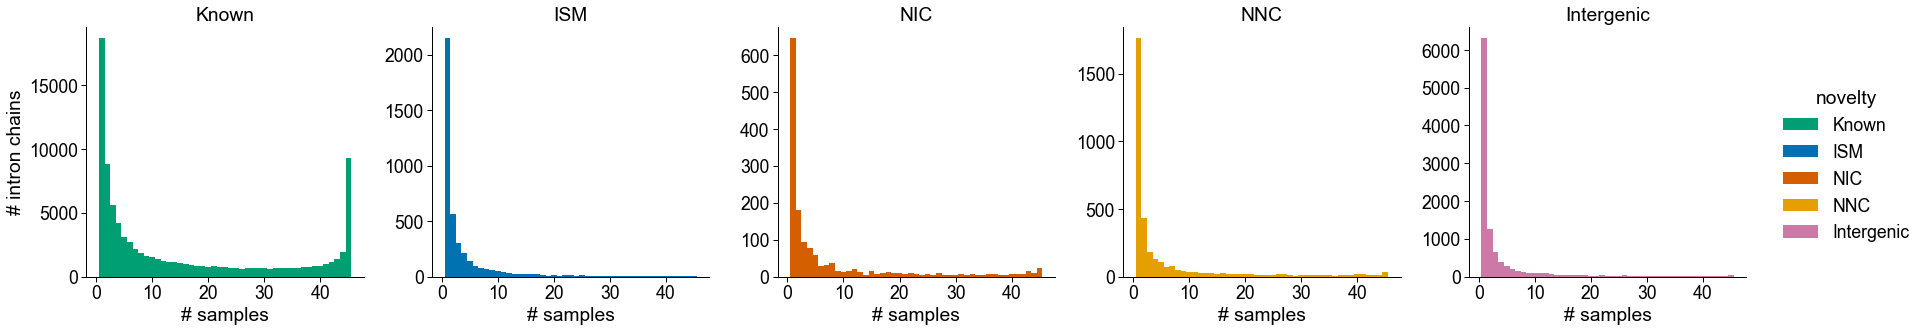

In [48]:
init_plot_settings(font_scale=2)
g = sns.displot(df,
            kind='hist',
            x='n_samples',
            alpha=1,
            discrete=True,
            col='novelty',
            col_order=order,
            hue_order=order,
            edgecolor=None,
            hue='novelty',
            palette=c_dict,
            facet_kws=dict(sharey='col'))
g.set_axis_labels('# samples', '# intron chains')
g.set_titles('{col_name}')

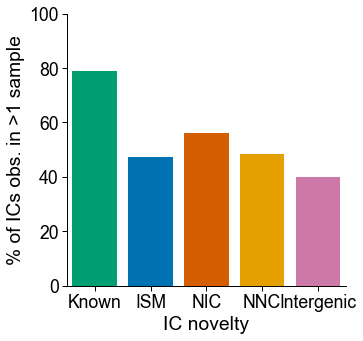

In [49]:
# what % of each category is unique to one sample?
temp = df.groupby(['novelty', 'n_samples']).nunique().rename({'Name':'n_ics'}, axis=1).reset_index()
temp['multiple_samples'] = temp.n_samples>1
temp = temp[['novelty', 'multiple_samples', 'n_ics']].groupby(['novelty', 'multiple_samples']).sum().reset_index()
temp['total_ics'] = temp.groupby('novelty')['n_ics'].transform('sum')

temp['perc'] = (temp.n_ics/temp.total_ics)*100

temp = temp.loc[temp.multiple_samples==True]
ax = sns.barplot(temp, x='novelty', palette=c_dict, order=order, y='perc', saturation=1)
xlabel = 'IC novelty'
ylabel = '% of ICs obs. in >1 sample'
_ = ax.set(xlabel=xlabel, ylabel=ylabel, ylim=(0,100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

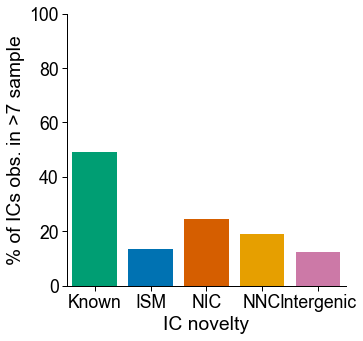

In [50]:
# what % of each category is unique to one sample?
temp = df.groupby(['novelty', 'n_samples']).nunique().rename({'Name':'n_ics'}, axis=1).reset_index()
temp['multiple_samples'] = temp.n_samples>7
temp = temp[['novelty', 'multiple_samples', 'n_ics']].groupby(['novelty', 'multiple_samples']).sum().reset_index()
temp['total_ics'] = temp.groupby('novelty')['n_ics'].transform('sum')

temp['perc'] = (temp.n_ics/temp.total_ics)*100

temp = temp.loc[temp.multiple_samples==True]
ax = sns.barplot(temp, x='novelty', palette=c_dict, order=order, y='perc', saturation=1)
xlabel = 'IC novelty'
ylabel = '% of ICs obs. in >7 sample'
_ = ax.set(xlabel=xlabel, ylabel=ylabel, ylim=(0,100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [151]:
# do we have any unspliced things?
df = pd.read_csv('agg_ics.tsv', sep='\t')

# reannotate novel genes novelty
df.loc[df.Name.str.contains('novel'), 'novelty'] = 'Intergenic'

df['monoexonic'] = df.Coordinates=='-'

# df.loc[~df.source.str.contains('47')].novelty.unique()

# # get only the novel transcripts
# df = df.loc[~df.source.str.contains('47')]

# get the transcripts that are expressed 
# df = df.loc[df.source.str.contains(',')]

# get ic : sample info
df['source'] = df.source.str.split(',')
df = df[['Name', 'source', 'novelty', 'monoexonic']].explode('source')
df['sample'] = df.source.str.split('_', expand=True)[0]

# remove things from gencode
print(len(df.index))
df = df.loc[df.source!='47']
print(len(df.index))

# get population info
meta = pd.read_csv('pantranscriptome_samples_metadata.tsv', sep='\t')
df = df.merge(meta[['sample', 'population']], how='left', on='sample')
df.drop('source', axis=1, inplace=True)

# remove duplicates that were detected in the tech reps of the same sample
print(len(df.index))
df.drop_duplicates(inplace=True)
print(len(df.index))

1145310
760171
760171
736907


In [154]:
df[['Name', 'monoexonic', 'novelty']].groupby(['novelty','monoexonic']).nunique().rename({'Name':'n_ic'}, axis=1).reset_index()

,novelty,monoexonic,n_ic
0,ISM,False,889
1,Intergenic,False,20046
2,Known,False,64303
3,Known,True,1977
4,NIC,False,426
5,NNC,False,37650


In [52]:
# how many ics of each novelty type?
# do we have any unspliced things?
df = pd.read_csv('agg_ics.tsv', sep='\t')

# reannotate novel genes novelty
df['gene_id'] = df.Name.str.split('_', n=1, expand=True)[0]
# reannotate novel genes novelty
# df.loc[df.Name.str.contains('novel'), 'novelty'] = 'Intergenic' # isoquant
df.loc[df.gene_id=='NA', 'novelty'] = 'Intergenic' # espresso

df['monoexonic'] = df.Coordinates=='-'

# df.loc[~df.source.str.contains('47')].novelty.unique()

# # get only the novel transcripts
# df = df.loc[~df.source.str.contains('47')]

# get the transcripts that are expressed 
# df = df.loc[df.source.str.contains(',')]

# get ic : sample info
df['source'] = df.source.str.split(',')
df = df[['Name', 'source', 'novelty', 'monoexonic']].explode('source')
df['sample'] = df.source.str.split('_', expand=True)[0]

# remove things from gencode
print(len(df.index))
df = df.loc[df.source!='47']
print(len(df.index))

# get population info
meta = pd.read_csv(meta_file, sep='\t')
df = df.merge(meta[['sample', 'population']], how='left', on='sample')
df.drop('source', axis=1, inplace=True)

# remove duplicates that were detected in the tech reps of the same sample
print(len(df.index))
df.drop_duplicates(inplace=True)
print(len(df.index))

df = df[['Name', 'novelty']].groupby('novelty').nunique().rename({'Name':'n_ic'}, axis=1).reset_index()

1866310
1481171
1481171
1481171


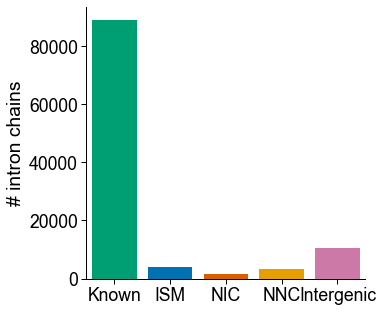

In [54]:
c_dict, order = get_talon_nov_colors(cats=df.novelty.unique().tolist())
init_plot_settings()
ax = sns.barplot(df, x='novelty', palette=c_dict, y='n_ic', order=order, saturation=1)
xlabel = ''
ylabel = '# intron chains'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [55]:
df

,novelty,n_ic
0,ISM,4079
1,Intergenic,10500
2,Known,89160
3,NIC,1470
4,NNC,3408
